# Projeto PCD: Simulação e Análise de Modelos de Difusão de Contaminantes em Água

## Profs. Álvaro e Denise (Turmas I e N)

**Objetivo**: Criar uma simulação que modele a difusão de contaminantes em um corpo d'água (como um lago ou rio), aplicando conceitos de paralelismo para acelerar o cálculo e observar o comportamento de poluentes ao longo do tempo. O projeto investigará o impacto de OpenMP, CUDA e MPI no tempo de execução e na precisão do modelo.

## Etapas do Projeto

### 1. Estudo do Modelo de Difusão
   - Estudar a Equação de Difusão/Transporte transiente, representada por:
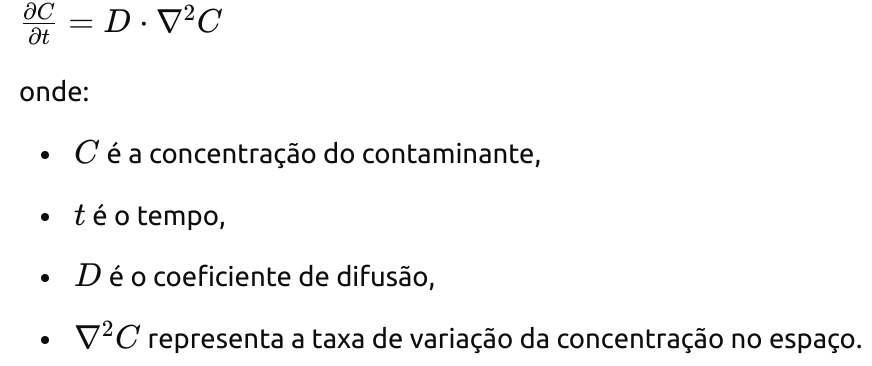

   - A equação diferencial pode ser aproximada (discretizada) no tempo e no espaço usando diferenças finitas em uma grade bidimensional, onde a discretização no espaço implica que cada célula da grade atualiza seu valor com base nas células vizinhas em cada iteração. O cálculo da grade atualizada deverá se repetir para que sejam feitas várias interações discretas no tempo.

### 2. Configuração do Ambiente e Parâmetros da Simulação
   - Configurar uma grade 2D onde cada célula representa a concentração de contaminantes em uma região do corpo d'água.
   - Definir o coeficiente de difusão \(D\), as condições de contorno (por exemplo, bordas onde o contaminante não se espalha) e as condições iniciais (como uma área de alta concentração de contaminante).
   - Definir uma quantidade fixa de interações no tempo como 1000 iterações.

### 3. Implementação com OpenMP (Simulação Local em CPU)
   - Usar OpenMP para paralelizar o cálculo de difusão entre os núcleos da CPU. Cada núcleo processa uma parte da grade, aplicando as regras de difusão às células sob sua responsabilidade.
   -**Entrega 1**: demonstrar o código em OpenMP e apresentar avaliação de desempenho com relação à versão sequencial.

### 4. Implementação com CUDA (Simulação em GPU)
   - Implementar a simulação em CUDA, onde cada célula da grade é processada por uma thread independente na GPU, utilizando um esquema de diferenças finitas para calcular o laplaciano de \(C\).
   - A execução em GPU permite simular uma grade maior e observar o ganho de desempenho com CUDA.
   -**Entrega 2**: demonstrar o código em CUDA e apresentar avaliação de desempenho com relação às versões anteriores.

### 5. Distribuição com MPI (Simulação em Larga Escala)
   - Dividir a grade em sub-regiões e distribuir o processamento entre várias máquinas usando MPI.
   - Cada máquina processa uma seção do corpo d'água e troca informações nas bordas com as máquinas vizinhas para garantir a continuidade da difusão de contaminantes entre as regiões.
   -**Entrega 3**: demonstrar o código em MPI hibrido (pode incluir trechos em OpenMP e CUDA) e apresentar avaliação de desempenho com relação às versões anteriores, porém destacando a escalabilidade possível apenas com MPI.

### 6. Artigo científico e Discussão dos Resultados
   - Criar gráficos que mostrem a evolução da concentração ao longo do tempo e comparar o tempo de execução entre as implementações.
   - Discutir as vantagens e limitações de cada abordagem, observando a escalabilidade, precisão e aplicabilidade em simulações ambientais.
   - Demonstrar visualmente os resultados que comprovem a corretude da simulação.
   -**Entrega Final**: entregar o resultado final no formato de artigo científico (modelo a ser disponibilizado).


## Ponto de Partida para a Implementação da Equação

Para aproximar a Equação de Difusão, podemos usar a seguinte fórmula de diferenças finitas central:
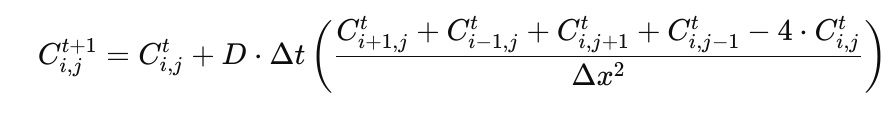

Abaixo está um trecho de código em C para uma implementação sequencial simples, o qual calcula a difusão do contaminante em uma grade de 2000x2000 ao longo de 500 ciclos. A concentração inicial está configurada no centro da grade, e o coeficiente de difusão \(D\) pode ser ajustado conforme necessário.


##Características do Projeto


*   **Caráter Científico:** Esse projeto aplica uma abordagem científica a um problema ambiental relevante.
*   **Exploração e Análise de Desempenho:** Permite uma análise detalhada das implementações em OpenMP, CUDA e MPI, com foco em desempenho e escalabilidade.
*   **Estrutura de Redação Científica:** O projeto estimula a criação de um artigo científico, semelhante a um trabalho de iniciação científica.


O grupo tem a liberdade de alterar o código, bem como alterar parâmetros/opções de compilação, para melhorar o seu desempenho, mantendo o seu objetivo, ou seja, calcular, sucessivamente, os novos valores para a matriz C_new, conforme a discretização citada acima.

Em caso de dúvida, será requisitado aos autores para que demonstrem e expliquem o funcionamento do código no laboratório de computação.

<div style="page-break-before: always;"></div>

In [ ]:
%%writefile difusao.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#define N 2000  // Tamanho da grade
#define T 500 // Número de iterações no tempo
#define D 0.1  // Coeficiente de difusão
#define DELTA_T 0.01
#define DELTA_X 1.0

void diff_eq(double **C, double **C_new) { //diff_eq(double C[N][N], double C_new[N][N]) {
    for (int t = 0; t < T; t++) {
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                C_new[i][j] = C[i][j] + D * DELTA_T * (
                    (C[i+1][j] + C[i-1][j] + C[i][j+1] + C[i][j-1] - 4 * C[i][j]) / (DELTA_X * DELTA_X)
                );
            }
        }
        // Atualizar matriz para a próxima iteração
        double difmedio = 0.;
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                difmedio += fabs(C_new[i][j] - C[i][j]);
                C[i][j] = C_new[i][j];
            }
        }
        if ((t%100) == 0)
          printf("interacao %d - diferenca=%g\n", t, difmedio/((N-2)*(N-2)));
    }
}

int main() {

    // Concentração inicial
    double **C = (double **)malloc(N * sizeof(double *));
    if (C == NULL) {
      fprintf(stderr, "Memory allocation failed\n");
      return 1;
    }
    for (int i = 0; i < N; i++) {
      C[i] = (double *)malloc(N * sizeof(double));
      if (C[i] == NULL) {
        fprintf(stderr, "Memory allocation failed\n");
        return 1;
      }
    }
    for (int i = 0; i < N; i++) {
      for (int j = 0; j < N; j++) {
        C[i][j] = 0.;
      }
    }

    // Concentração para a próxima iteração
    double **C_new = (double **)malloc(N * sizeof(double *));
    if (C_new == NULL) {
      fprintf(stderr, "Memory allocation failed\n");
      return 1;
    }
    for (int i = 0; i < N; i++) {
      C_new[i] = (double *)malloc(N * sizeof(double));
      if (C_new[i] == NULL) {
        fprintf(stderr, "Memory allocation failed\n");
        return 1;
      }
    }
    for (int i = 0; i < N; i++) {
      for (int j = 0; j < N; j++) {
        C_new[i][j] = 0.;
      }
    }

    // Inicializar uma concentração alta no centro
    C[N/2][N/2] = 1.0;

    // Executar as iterações no tempo para a equação de difusão
    diff_eq(C, C_new);

    // Exibir resultado para verificação
    printf("Concentração final no centro: %f\n", C[N/2][N/2]);
    return 0;
}

Writing difusao.c


In [ ]:
!more /proc/cpuinfo &> processador.txt
!more processador.txt | grep model

model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!rm difusao.x
!gcc difusao.c -o difusao.x
!time ./difusao.x

rm: cannot remove 'difusao.x': No such file or directory
interacao 0 - diferenca=2.00401e-09
interacao 100 - diferenca=1.23248e-09
interacao 200 - diferenca=7.81794e-10
interacao 300 - diferenca=5.11528e-10
interacao 400 - diferenca=4.21632e-10
Concentração final no centro: 0.216512

real	0m36.231s
user	0m35.859s
sys	0m0.062s


In [ ]:
!apt-get update -y
!apt-get install -y mpich


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [66.7 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,311 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,663 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,606 kB]
Get:13 https://ppa.launchpadcontent.net

In [ ]:
%%writefile diffusao_mpi.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <mpi.h>

#define N 2000
#define T 500
#define D 0.1
#define DELTA_T 0.01
#define DELTA_X 1.0

void diff_eq(double *C, double *C_new, int start, int end) {
    for (int t = 0; t < T; t++) {
        for (int i = start; i < end; i++) {
            for (int j = 1; j < N - 1; j++) {
                C_new[i * N + j] = C[i * N + j] + D * DELTA_T * (
                    (C[(i+1) * N + j] + C[(i-1) * N + j] + C[i * N + (j+1)] + C[i * N + (j-1)] - 4 * C[i * N + j]) / (DELTA_X * DELTA_X)
                );
            }
        }
        for (int i = start; i < end; i++) {
            for (int j = 1; j < N - 1; j++) {
                C[i * N + j] = C_new[i * N + j];
            }
        }
    }
}

int main(int argc, char *argv[]) {
    int rank, size;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int rows_per_proc = N / size;
    int start = rank * rows_per_proc;
    int end = (rank == size - 1) ? N : start + rows_per_proc;

    // Alocar matriz como um único bloco contínuo
    double *C = (double *)calloc(N * N, sizeof(double));
    double *C_new = (double *)calloc(N * N, sizeof(double));
    if (C == NULL || C_new == NULL) {
        fprintf(stderr, "Erro na alocação de memória.\n");
        MPI_Abort(MPI_COMM_WORLD, 1);
    }

    // Inicializar concentração no processo 0
    if (rank == 0) {
        C[(N/2) * N + (N/2)] = 1.0;
    }

    // Corrigir MPI_Bcast usando a matriz contínua
    MPI_Bcast(C, N * N, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    diff_eq(C, C_new, start, end);

    // Apenas o rank 0 imprime o resultado final
    if (rank == 0) {
        printf("Concentração final no centro: %f\n", C[(N/2) * N + (N/2)]);
    }

    free(C);
    free(C_new);
    MPI_Finalize();
    return 0;
}


Writing diffusao_mpi.c


In [ ]:
!mpicc diffusao_mpi.c -o diffusao_mpi
!mpirun --allow-run-as-root -np 1 ./diffusao_mpi
!time ./diffusao_mpi


Concentração final no centro: 0.216512
Concentração final no centro: 0.216512

real	0m29.481s
user	0m28.870s
sys	0m0.079s


In [ ]:
!apt-get update -y
!apt-get install -y mpich libomp-dev


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,230 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,606 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 4,223 kB in 1s (2,865 kB/s)
Reading package lists... Done
W: Skipp

In [ ]:
%%writefile diffusao_mpi_openmp.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <mpi.h>
#include <omp.h>

#define N 2000
#define T 500
#define D 0.1
#define DELTA_T 0.01
#define DELTA_X 1.0

void diff_eq(double *C, double *C_new, int start, int end) {
    for (int t = 0; t < T; t++) {
        #pragma omp parallel for collapse(2)
        for (int i = start; i < end; i++) {
            for (int j = 1; j < N - 1; j++) {
                C_new[i * N + j] = C[i * N + j] + D * DELTA_T * (
                    (C[(i+1) * N + j] + C[(i-1) * N + j] + C[i * N + (j+1)] + C[i * N + (j-1)] - 4 * C[i * N + j]) / (DELTA_X * DELTA_X)
                );
            }
        }

        #pragma omp parallel for collapse(2)
        for (int i = start; i < end; i++) {
            for (int j = 1; j < N - 1; j++) {
                C[i * N + j] = C_new[i * N + j];
            }
        }
    }
}

int main(int argc, char *argv[]) {
    int rank, size, threads;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Definir número de threads OpenMP
    #pragma omp parallel
    {
        threads = omp_get_num_threads();
    }

    if (rank == 0) {
        printf("Executando com %d processos MPI e %d threads OpenMP por processo.\n", size, threads);
    }

    int rows_per_proc = N / size;
    int start = rank * rows_per_proc;
    int end = (rank == size - 1) ? N : start + rows_per_proc;

    double *C = (double *)calloc(N * N, sizeof(double));
    double *C_new = (double *)calloc(N * N, sizeof(double));
    if (C == NULL || C_new == NULL) {
        fprintf(stderr, "Erro na alocação de memória.\n");
        MPI_Abort(MPI_COMM_WORLD, 1);
    }

    if (rank == 0) {
        C[(N/2) * N + (N/2)] = 1.0;
    }

    MPI_Bcast(C, N * N, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    diff_eq(C, C_new, start, end);

    if (rank == 0) {
        printf("Concentração final no centro: %f\n", C[(N/2) * N + (N/2)]);
    }

    free(C);
    free(C_new);
    MPI_Finalize();
    return 0;
}


Overwriting diffusao_mpi_openmp.c


In [ ]:
!mpicc -fopenmp diffusao_mpi_openmp.c -o diffusao_mpi_openmp


In [ ]:
!export OMP_NUM_THREADS=4
!time ./diffusao_mpi_openmp

Executando com 1 processos MPI e 2 threads OpenMP por processo.
Concentração final no centro: 0.216512

real	0m26.337s
user	0m44.770s
sys	0m0.190s
